In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('ggplot')
plt.rc('patch', force_edgecolor=True,edgecolor='black')
plt.rc('hist', bins='auto')

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

Using TensorFlow backend.


In [4]:
train = pd.read_csv('wrangled_data/training_post_wrangle.csv')

test_full = pd.read_csv('wrangled_data/testing_post_wrangle.csv')

test = test_full.loc[:,['ID', 'shop_id', 'item_id']]

In [5]:
dataset = train.pivot_table(index = ['shop_id','item_id'], values = ['item_cnt_month'], columns =['date_block_num'], aggfunc='sum')

In [6]:
dataset.head(3)

item_cnt_month                                                \
date_block_num            0.0   1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0    
shop_id item_id                                                                
0       30                 0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        31                 0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        32                 6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                 ...                                                    
date_block_num   ... 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0  
shop_id item_id  ...                                                    
0       30       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[3 rows x 34 columns]

In [7]:
dataset.reset_index(inplace = True)

In [8]:
dataset.head(3)

shop_id item_id item_cnt_month                                 \
date_block_num                            0.0   1.0  2.0  3.0  4.0  5.0  6.0   
0                    0      30            0.0  31.0  0.0  0.0  0.0  0.0  0.0   
1                    0      31            0.0  11.0  0.0  0.0  0.0  0.0  0.0   
2                    0      32            6.0  10.0  0.0  0.0  0.0  0.0  0.0   

                     ...                                                    
date_block_num  7.0  ... 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0  
0               0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1               0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2               0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[3 rows x 36 columns]

In [9]:
# df = pd.merge(test, train, on = ['item_id','shop_id'],how = 'left')

In [10]:
dataset = pd.merge(test, dataset, on = ['item_id','shop_id'], how='left')

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [11]:
dataset.head()

,ID,shop_id,item_id,"(item_cnt_month, 0.0)","(item_cnt_month, 1.0)","(item_cnt_month, 2.0)","(item_cnt_month, 3.0)","(item_cnt_month, 4.0)","(item_cnt_month, 5.0)","(item_cnt_month, 6.0)",...,"(item_cnt_month, 24.0)","(item_cnt_month, 25.0)","(item_cnt_month, 26.0)","(item_cnt_month, 27.0)","(item_cnt_month, 28.0)","(item_cnt_month, 29.0)","(item_cnt_month, 30.0)","(item_cnt_month, 31.0)","(item_cnt_month, 32.0)","(item_cnt_month, 33.0)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
dataset.fillna(0,inplace = True)

dataset.head()

,ID,shop_id,item_id,"(item_cnt_month, 0.0)","(item_cnt_month, 1.0)","(item_cnt_month, 2.0)","(item_cnt_month, 3.0)","(item_cnt_month, 4.0)","(item_cnt_month, 5.0)","(item_cnt_month, 6.0)",...,"(item_cnt_month, 24.0)","(item_cnt_month, 25.0)","(item_cnt_month, 26.0)","(item_cnt_month, 27.0)","(item_cnt_month, 28.0)","(item_cnt_month, 29.0)","(item_cnt_month, 30.0)","(item_cnt_month, 31.0)","(item_cnt_month, 32.0)","(item_cnt_month, 33.0)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
dataset.drop(['shop_id','item_id','ID'],inplace = True, axis = 1)
dataset.head()

,"(item_cnt_month, 0.0)","(item_cnt_month, 1.0)","(item_cnt_month, 2.0)","(item_cnt_month, 3.0)","(item_cnt_month, 4.0)","(item_cnt_month, 5.0)","(item_cnt_month, 6.0)","(item_cnt_month, 7.0)","(item_cnt_month, 8.0)","(item_cnt_month, 9.0)",...,"(item_cnt_month, 24.0)","(item_cnt_month, 25.0)","(item_cnt_month, 26.0)","(item_cnt_month, 27.0)","(item_cnt_month, 28.0)","(item_cnt_month, 29.0)","(item_cnt_month, 30.0)","(item_cnt_month, 31.0)","(item_cnt_month, 32.0)","(item_cnt_month, 33.0)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
dataset.shape

(214200, 34)

In [15]:
scaler = RobustScaler().fit(dataset)
dataset_scaled = scaler.transform(dataset)

In [16]:
# train.head()
train.shape

(14411682, 12)

In [17]:
# X we will keep all columns execpt the last one 
X_train = np.expand_dims(dataset_scaled[:,:-1],axis = 2)
# the last column is our label
y_train = dataset_scaled[:,-1:]

# for test we keep all the columns execpt the first one
X_test = np.expand_dims(dataset_scaled[:,1:],axis = 2)

# lets have a look on the shape 
print(X_train.shape,y_train.shape,X_test.shape)

(214200, 33, 1) (214200, 1) (214200, 33, 1)


In [18]:
win_length = 59*34*34
batch_size = 34*34
# num_features = len(features)

train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(X_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
tune_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(X_test, length=win_length, sampling_rate=1, batch_size=batch_size)

TypeError: __init__() missing 1 required positional argument: 'targets'

In [30]:
# scaler = StandardScaler().fit(X_train_0)
# X_train = scaler.transform(X_train_0)
# X_test = scaler.transform(X_test_0)

# # lets have a look on the shape 
# print(X_train.shape,y_train.shape,X_test.shape)

In [31]:
# our defining our model 
# model_lstm = Sequential()
# model_lstm.add(LSTM(units = 64,input_shape = (X_train.shape[1], X_train.shape[2])))
# model_lstm.add(Dropout(0.4))
# model_lstm.add(Dense(1))

# model_lstm.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
# model_lstm.summary()


model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(128, input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_lstm.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model_lstm.add(tf.keras.layers.LSTM(128, return_sequences=True))
model_lstm.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model_lstm.add(tf.keras.layers.Dropout(0.3))
model_lstm.add(tf.keras.layers.LSTM(64, return_sequences=False))
model_lstm.add(tf.keras.layers.Dropout(0.3))
model_lstm.add(tf.keras.layers.Dense(1))

model_lstm.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error']) #Starting learning rate
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 33, 128)           66560     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 33, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 33, 128)           131584    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 33, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 33, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

In [32]:
history_lstm = model_lstm.fit(X_train,y_train,batch_size = 4096,epochs = 15)

Train on 214200 samples
Epoch 1/15
214200/214200 [==============================] - 92s 430us/sample - loss: 30.1629 - mean_squared_error: 30.1629
Epoch 2/15
214200/214200 [==============================] - 87s 405us/sample - loss: 29.9082 - mean_squared_error: 29.9082
Epoch 3/15
214200/214200 [==============================] - 87s 407us/sample - loss: 29.8165 - mean_squared_error: 29.8165
Epoch 4/15
214200/214200 [==============================] - 88s 413us/sample - loss: 29.7356 - mean_squared_error: 29.7356
Epoch 5/15
214200/214200 [==============================] - 88s 409us/sample - loss: 29.6420 - mean_squared_error: 29.6420
Epoch 6/15
214200/214200 [==============================] - 88s 410us/sample - loss: 29.6042 - mean_squared_error: 29.6042
Epoch 7/15
214200/214200 [==============================] - 87s 407us/sample - loss: 29.4861 - mean_squared_error: 29.4861
Epoch 8/15
214200/214200 [==============================] - 88s 409us/sample - loss: 29.3973 - mean_squared_error: 

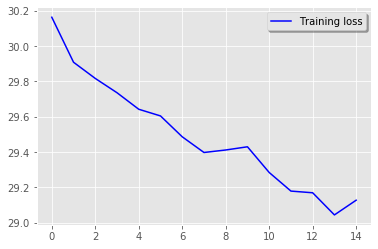

In [33]:
# Plot the loss curves for training
plt.plot(history_lstm.history['loss'], color='b', label="Training loss")
plt.legend(loc='best', shadow=True)

In [34]:
# creating submission file 
submission_pfs = model_lstm.predict(X_test)
# we will keep every value between 0 and 20
submission_pfs = submission_pfs.clip(0,20)

In [35]:
fullset = np.concatenate((dataset_scaled, submission_pfs), 1)

In [36]:
fullset[:,1:].shape

(214200, 34)

In [37]:
submission_unscaled = scaler.inverse_transform(fullset[:,1:])

In [38]:
submission_unscaled[:,-1].shape

(214200,)

In [39]:
# creating dataframe with required columns 
submission = pd.DataFrame({'ID':test['ID'],'item_cnt_month':submission_unscaled[:,-1].ravel()})
# creating csv file from dataframe
submission.to_csv('submission_files/robustscale_no_encoding.csv',index = False)

In [40]:
submission.head(3)

,ID,item_cnt_month
0,0,0.483135
1,1,0.131865
2,2,0.760975


In [41]:
submission.shape, test.shape

((214200, 2), (214200, 3))